In [4]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sb
from wordcloud import WordCloud

In [5]:
dataTroca = pd.read_csv('events.csv', low_memory=False)
dataTroca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011288 entries, 0 to 1011287
Data columns (total 23 columns):
timestamp                   1011288 non-null object
event                       1011288 non-null object
person                      1011288 non-null object
url                         82756 non-null object
sku                         563838 non-null object
model                       564284 non-null object
condition                   563836 non-null object
storage                     563836 non-null object
color                       563836 non-null object
skus                        221699 non-null object
search_term                 48967 non-null object
staticpage                  3598 non-null object
campaign_source             82796 non-null object
search_engine               50957 non-null object
channel                     87378 non-null object
new_vs_returning            87378 non-null object
city                        87378 non-null object
region                    

In [6]:
#Convierto la fecha de crecion en un datetime64[ns]
dataTroca['timestamp'] = pd.to_datetime(dataTroca['timestamp'])

In [7]:
#Hay muchos null. Trato de llenar los datos con los datos de cada persona
groupbyPersonas = dataTroca.loc[:,['person', 'event']].groupby('person')
dicc = {}
for clave, data in groupbyPersonas:
    lista = []
    lista = data.drop_duplicates(subset = 'event', keep = 'first')['event'].tolist()
    dicc[clave] = lista

In [8]:
#Obtengo una lista de todos los eventos que tiene esa persona
dataTroca['eventos'] = dataTroca['person'].map(lambda x: dicc[x])
#Obtengo los dias de la seman
dataTroca['dayweek'] = dataTroca.timestamp.dt.dayofweek
#Obtengo la fecha
dataTroca['fecha'] = dataTroca.timestamp.dt.date
#Separo la marca
dataTroca['marca'] = dataTroca['model'].map(lambda x: str(x).split()[0])

In [9]:
#cantidad de personas que ingresaron 27624.
groupbyCantEventos = dataTroca.groupby('person', as_index = False)['event'].agg({'cantEventos': 'count'})
groupbyCantEventos.sort_values(by = 'cantEventos', ascending = False)
dataTroca = pd.merge(dataTroca, groupbyCantEventos, on = 'person')

In [10]:
personasConVisitas = dataTroca.loc[dataTroca['event'] == 'visited site']\
                              .drop_duplicates(subset = 'person', keep = 'first')['person'].tolist()

dataNotVisit = dataTroca.loc[dataTroca['person'].isin(personasConVisitas)]

In [11]:
data2 = dataNotVisit.loc[dataNotVisit['event'] == 'visited site'].groupby(['person', 'fecha'], as_index = False).agg({'city': 'first', 'region': 'first', 'country': 'first', 'device_type': 'first', 'operating_system_version': 'first', 'channel': 'first', 'new_vs_returning': 'first'})

In [12]:
events = pd.merge(dataNotVisit, data2, on = ['person', 'fecha'])
events.drop(['region_x', 'device_type_x', 'operating_system_version_x', 'country_x', 'city_x', 'channel_x', 'new_vs_returning_x'], axis = 1, inplace = True)
events.rename(columns = {'region_y': 'region', 'device_type_y': 'device_type', 'operating_system_version_y': 'SO', 'city_y': 'city', 'country_y': 'country', 'channel_y': 'channel', 'new_vs_returning_y': 'new_vs_returning'}, inplace =True)

In [13]:
def obtenerSistema(so):
    sistema = so.split()
    if len(sistema) > 1:
        otro = sistema[1].split('.')[0]
        return sistema[0] + ' ' + otro
    else:
        return sistema[0]
    
events['SO'] = events['SO'].map(obtenerSistema)

In [14]:
events.head() #Dataframe a utilizar

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,fecha,marca,cantEventos,city,region,country,device_type,SO,channel,new_vs_returning
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,2018-05-31,nan,4,Camaragibe,Pernambuco,Brazil,Smartphone,Android 6,Paid,New
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2018-05-31,nan,4,Camaragibe,Pernambuco,Brazil,Smartphone,Android 6,Paid,New
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,2018-05-31,iPhone,4,Camaragibe,Pernambuco,Brazil,Smartphone,Android 6,Paid,New
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,2018-05-31,iPhone,4,Camaragibe,Pernambuco,Brazil,Smartphone,Android 6,Paid,New
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,2018-05-29,Samsung,4,Rio de Janeiro,Rio de Janeiro,Brazil,Smartphone,Android 5,Paid,New


In [15]:
weekDays = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
monthNames = ["", 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
def get_day_name(x):
    return weekDays[x['weekday']]

def get_month_name(x):
    return monthNames[x['month']]

#Agrego columnas
events['brand'] = events['model'].str.split().str.get(0)
events['week'] = events.timestamp.dt.week
events['month'] = events.timestamp.dt.month
events['month_name'] = events.apply(get_month_name, axis=1)
events['weekday'] = events.timestamp.dt.weekday
events['weekday_name'] = events.apply(get_day_name, axis=1)
events['hour'] = events.timestamp.dt.hour
events['month_day'] = events.timestamp.dt.day
events.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,channel,new_vs_returning,brand,week,month,month_name,weekday,weekday_name,hour,month_day
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,Paid,New,NaN,22,5,Mayo,3,Jueves,23,31
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Paid,New,NaN,22,5,Mayo,3,Jueves,23,31
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,Paid,New,iPhone,22,5,Mayo,3,Jueves,23,31
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,Paid,New,iPhone,22,5,Mayo,3,Jueves,23,31
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,Paid,New,Samsung,22,5,Mayo,1,Martes,13,29


In [16]:
# Analizando los eventos
events['event'].value_counts()

viewed product       522937
brand listing         97376
visited site          87378
ad campaign hit       82071
generic listing       66932
searched products     55247
search engine hit     50645
checkout              32509
staticpage             3533
conversion              961
lead                    378
Name: event, dtype: int64

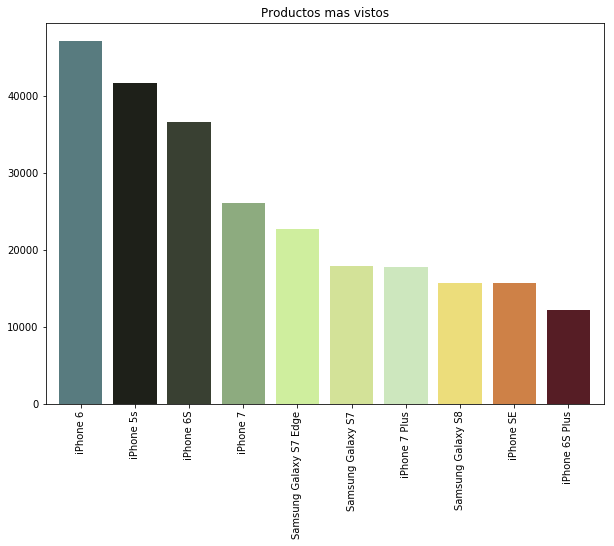

In [71]:
# Cuales son los productos mas visitados ?
plot_most_viewed_products = events.loc[events['event'] == 'viewed product', :]['model'].value_counts().head(10).plot(kind='bar', figsize=(10, 7), width=0.8, title="Productos mas vistos", color=['#587b7f', '#1e2019', '#394032', '#8dab7f', '#cfee9e', '#d3e298', '#cde7be', '#ecdd7b', '#ce8147', '#561d25'])
plot_most_viewed_products.get_figure().savefig('most_viewed_products.jpg')

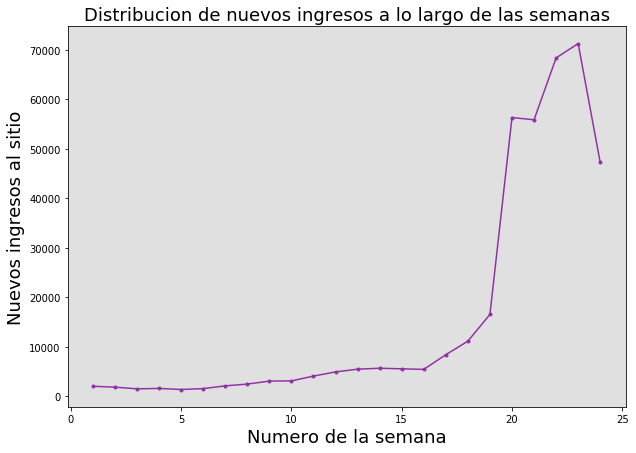

In [70]:
# Veamos evolutivos semana a semana de los nuevos ingresos a la plataforma
grouped_by_week = events.loc[events['new_vs_returning'] == "New", :].groupby('week').size()
plot_week_evolution = grouped_by_week.plot(kind='line', style='.-', figsize=(10, 7), color='#9032a3')
plot_week_evolution.set_title("Distribucion de nuevos ingresos a lo largo de las semanas", fontsize=18)
plot_week_evolution.set_ylabel("Nuevos ingresos al sitio", fontsize=18)
plot_week_evolution.set_xlabel("Numero de la semana", fontsize=18)
plot_week_evolution.set_facecolor('#E0E0E0')
plot_week_evolution
plot_week_evolution.get_figure().savefig('week_evolution_new_connections.jpg')

In [20]:
# Hay un salto de la semana 19(07/05 al 13/05) a la 20(14/05 al 20/05) y una caida de la semana 23(04/06 al 10/06) a la 24(11/06 al 17/06). Veamos que fechas son
#events.groupby('week').get_group(24)['timestamp64'].dt.date.value_counts() 

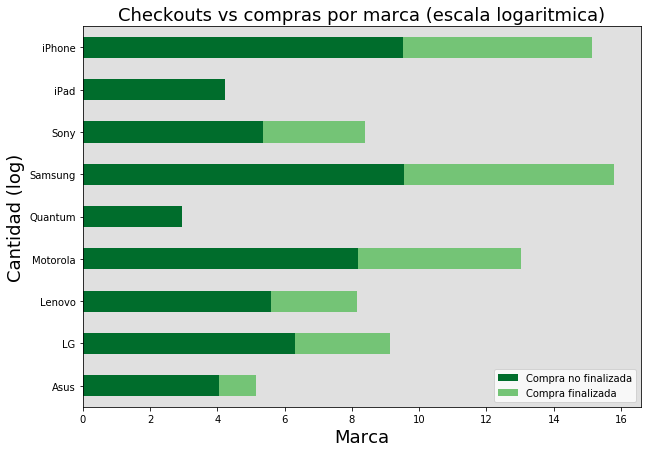

In [121]:
#Comparacion checkout/compra separado por marca
checkout_conversion_grouped_by_brand = events.loc[(events['event'] == 'checkout') | (events['event'] == 'conversion'), :].groupby(['brand', 'event']).agg({'timestamp' : 'size'})
checkout_conversion_grouped_by_brand = checkout_conversion_grouped_by_brand.groupby(level=0).transform(lambda x: np.log(x+1))
checkout_conversion_grouped_by_brand.reset_index(inplace=True)
pivot_checkout = checkout_conversion_grouped_by_brand.pivot(index='brand', columns='event', values='timestamp')
pivot_checkout.fillna(0)
plot_checkout_vs_conversion = pivot_checkout[['checkout', 'conversion']].plot.barh(figsize=(10, 7), stacked=True, color=["#006D2C", "#74C476"])
plot_checkout_vs_conversion.set_title("Checkouts vs compras por marca (escala logaritmica)", fontsize=18)
plot_checkout_vs_conversion.set_ylabel("Cantidad (log)", fontsize=18)
plot_checkout_vs_conversion.set_xlabel("Marca", fontsize=18)
plot_checkout_vs_conversion.set_facecolor('#E0E0E0')
plot_checkout_vs_conversion.legend(['Compra no finalizada', 'Compra finalizada'])

#for patch in plot_checkout_vs_conversion.patches:
#    if patch.get_width() > 0:
#        bl = patch.get_xy()
#        x = 0.5 * patch.get_width() + bl[0]
#        y = 0.4 * patch.get_height() + bl[1] 
#        plot_checkout_vs_conversion.text(x,y,"%d" %(patch.get_width()), ha='center', weight='bold', color='white')
        
plot_checkout_vs_conversion.get_figure().savefig('checkout_vs_conversions_by_brand.jpg')

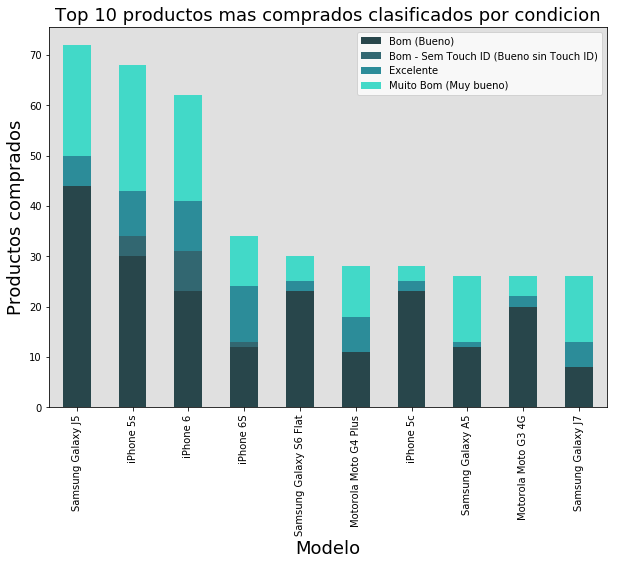

In [68]:
#Productos mas comprados (conversion)
group_most_purchased_products = events.loc[events['event'] == "conversion", :].groupby(['model', 'condition']).agg({'timestamp' : 'size'})
group_most_purchased_products.reset_index(inplace=True)
group_most_purchased_products
pivot_most_purchased_products = group_most_purchased_products.pivot_table(index='model', columns='condition', values='timestamp', aggfunc=np.sum, margins=True).fillna(0)
pivot_most_purchased_products = pivot_most_purchased_products.sort_values(ascending=False, by='All').drop(['All']).drop('All', axis=1)
plot_most_purchased_products = pivot_most_purchased_products.head(10).plot.bar(figsize=(10, 7), stacked=True, color=['#28464b', '#326771', '#2c8c99', '#42d9c8'])
plot_most_purchased_products.set_title("Top 10 productos mas comprados clasificados por condicion", fontsize=18)
plot_most_purchased_products.set_ylabel("Productos comprados", fontsize=18)
plot_most_purchased_products.set_xlabel("Modelo", fontsize=18)
plot_most_purchased_products.set_facecolor('#E0E0E0')
plot_most_purchased_products.legend(['Bom (Bueno)', 'Bom - Sem Touch ID (Bueno sin Touch ID)', 'Excelente', 'Muito Bom (Muy bueno)'])
plot_most_purchased_products.get_figure().savefig('most_purchased_products_by_condition.jpg')

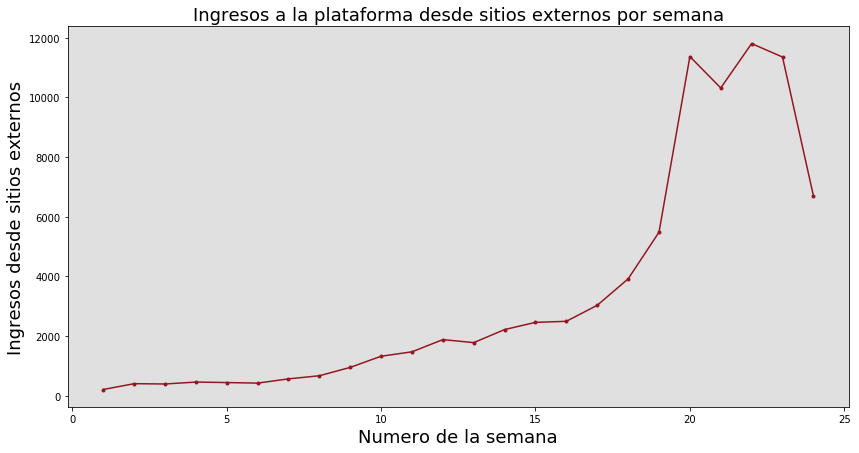

In [67]:
#Ingresos a la plataforma provenientes de campanias de publicidad externa
plot_week_evolution_from_extern_campaigns = events.loc[events['event'] == "ad campaign hit", :].groupby('week').size().plot(kind='line', style='.-', figsize=(14, 7), color='#931621')
plot_week_evolution_from_extern_campaigns.set_title("Ingresos a la plataforma desde sitios externos por semana", fontsize=18)
plot_week_evolution_from_extern_campaigns.set_ylabel("Ingresos desde sitios externos", fontsize=18)
plot_week_evolution_from_extern_campaigns.set_xlabel("Numero de la semana", fontsize=18)
plot_week_evolution_from_extern_campaigns.set_facecolor('#E0E0E0')
plot_week_evolution_from_extern_campaigns
plot_week_evolution_from_extern_campaigns.get_figure().savefig('week_evolution_from_externs_campaigns.jpg')

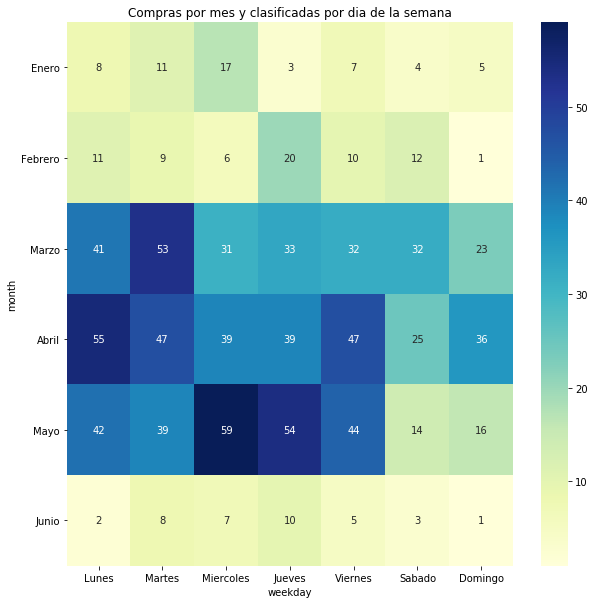

In [66]:
#Grafico de compras en la plataforma separado por mes y dia de la semana
pivot_help = events.loc[(events['event'] == "conversion"), ['weekday', 'month']].pivot_table(index='month', columns='weekday', aggfunc='size', fill_value=0)
#pivot_help = pivot_help.reindex(index=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio'])
#pivot_help.columns.levels[1] = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
#pivot_help
fig, ax = plt.pyplot.subplots(figsize=(10, 10))
heatmap_sales_vs_month_week_day = sb.heatmap(pivot_help, cmap="YlGnBu", ax=ax, annot=True)
heatmap_sales_vs_month_week_day.set_xticklabels(weekDays)
heatmap_sales_vs_month_week_day.set_yticklabels(['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio'], rotation=0)
heatmap_sales_vs_month_week_day.set_title('Compras por mes y clasificadas por dia de la semana')
heatmap_sales_vs_month_week_day.get_figure().savefig('heatmap_month_vs_weekday.jpg')

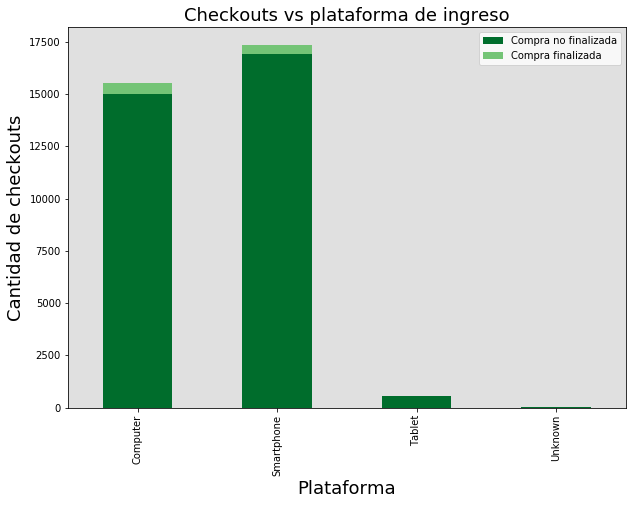

In [25]:
#Cantidad de checkouts por plataforma de ingreso
grouped_checkouts_vs_platform = events.loc[(events['event'] == 'checkout') | (events['event'] == 'conversion'), :].groupby(['device_type', 'event']).count()
grouped_checkouts_vs_platform.reset_index(inplace=True)
pivot_checkouts_vs_platform = grouped_checkouts_vs_platform.pivot(index='device_type', columns='event', values='timestamp').fillna(0)
plot_checkout_vs_platform = pivot_checkouts_vs_platform[['checkout', 'conversion']].plot.bar(figsize=(10, 7), stacked=True, color=["#006D2C", "#74C476"])
plot_checkout_vs_platform.set_title("Checkouts vs plataforma de ingreso", fontsize=18)
plot_checkout_vs_platform.set_ylabel("Cantidad de checkouts", fontsize=18)
plot_checkout_vs_platform.set_xlabel("Plataforma", fontsize=18)
plot_checkout_vs_platform.set_facecolor('#E0E0E0')
plot_checkout_vs_platform.legend(['Compra no finalizada', 'Compra finalizada'])

In [26]:
#Cantidad de compras por plataforma de ingreso
events.loc[(events['event'] == 'searched products') & (events['search_term'] == '128gb'), :]

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,channel,new_vs_returning,brand,week,month,month_name,weekday,weekday_name,hour,month_day
158354,2018-04-04 23:10:26,searched products,2a587cb5,NaN,NaN,NaN,NaN,NaN,NaN,"10085,9946,10296,10156,10114,13193,11710",...,Paid,Returning,NaN,14,4,Abril,2,Miercoles,23,4
216969,2018-05-23 12:04:22,searched products,3a0b3697,NaN,NaN,NaN,NaN,NaN,NaN,"10085,10030,9987,10197,9902,11890,9944,13192,1...",...,Direct,Returning,NaN,21,5,Mayo,2,Miercoles,12,23
216970,2018-05-23 12:04:31,searched products,3a0b3697,NaN,NaN,NaN,NaN,NaN,NaN,13192,...,Direct,Returning,NaN,21,5,Mayo,2,Miercoles,12,23
216975,2018-05-23 12:04:55,searched products,3a0b3697,NaN,NaN,NaN,NaN,NaN,NaN,13192,...,Direct,Returning,NaN,21,5,Mayo,2,Miercoles,12,23
216976,2018-05-23 12:04:58,searched products,3a0b3697,NaN,NaN,NaN,NaN,NaN,NaN,"10085,10030,9987,10197,9902,11890,9944,13192,1...",...,Direct,Returning,NaN,21,5,Mayo,2,Miercoles,12,23
216977,2018-05-23 12:05:13,searched products,3a0b3697,NaN,NaN,NaN,NaN,NaN,NaN,13192,...,Direct,Returning,NaN,21,5,Mayo,2,Miercoles,12,23
217030,2018-05-23 17:25:50,searched products,3a0b3697,NaN,NaN,NaN,NaN,NaN,NaN,"9987,10030,10196,9902,10085,9944,13192,10294,1...",...,Direct,Returning,NaN,21,5,Mayo,2,Miercoles,17,23
217031,2018-05-23 17:25:54,searched products,3a0b3697,NaN,NaN,NaN,NaN,NaN,NaN,"13192,13250",...,Direct,Returning,NaN,21,5,Mayo,2,Miercoles,17,23
217032,2018-05-23 17:25:58,searched products,3a0b3697,NaN,NaN,NaN,NaN,NaN,NaN,"13192,13250",...,Direct,Returning,NaN,21,5,Mayo,2,Miercoles,17,23
379081,2018-05-30 19:52:57,searched products,63ebf0fe,NaN,NaN,NaN,NaN,NaN,NaN,"9944,10030,10084,9902,10198,11892,13192,10156,...",...,Paid,Returning,NaN,22,5,Mayo,2,Miercoles,19,30


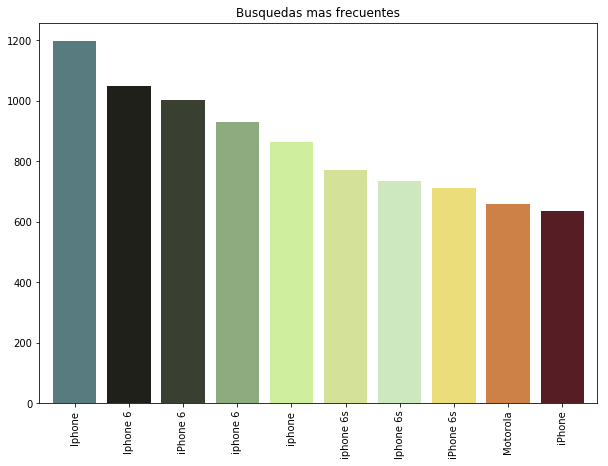

In [65]:
#Veamos que pasa con las busquedas
searched_terms = events.loc[events['event'] == 'searched products', :]
plot_most_searched_terms = searched_terms['search_term'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10, 7), width=0.8, title="Busquedas mas frecuentes", color=['#587b7f', '#1e2019', '#394032', '#8dab7f', '#cfee9e', '#d3e298', '#cde7be', '#ecdd7b', '#ce8147', '#561d25'])
plot_most_searched_terms.get_figure().savefig('busquedas_mas_frecuentes.jpg')

In [28]:
#Facilmente podemos ver que lo mas buscado es iPhone
#Veamos que pasa con los mal escritos

searched_terms_not_iphone = searched_terms.loc[(~searched_terms['search_term'].isnull()) & (searched_terms.search_term.str.lower().str.contains("sansung", na=False) | (searched_terms.search_term.str.lower().str.contains("ifone", na=False))), :]
searched_terms_not_iphone['search_term'].value_counts().sum()

505

In [29]:
#505 busqueda fueron mal realizadas ya sea por error de tipeo o desconocimiento de como se escribe la marca,
#Si buscamos en trocafone alguno de estos dos valores, nos damos cuenta que nos dice "no hay resultado para 'term'"
#Podrian trabajar en un predictor/corrector de terminos de busqueda
#Que paso con los usuarios que realizaron estas busquedas?
wrong_searchs_persons = list(searched_terms_not_iphone.person.unique())

In [30]:
#Busquemos checkouts y conversiones de estas personas
events.loc[((~events['search_term'].isnull()) & (events.search_term.str.lower().str.contains("sansung", na=False) | (events.search_term.str.lower().str.contains("ifone", na=False)))) | ((events['person'].isin(wrong_searchs_persons))), :]


,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,channel,new_vs_returning,brand,week,month,month_name,weekday,weekday_name,hour,month_day
1569,2018-03-15 02:40:30,ad campaign hit,0084710f,/,NaN,NaN,NaN,NaN,NaN,NaN,...,Paid,New,NaN,11,3,Marzo,3,Jueves,2,15
1570,2018-03-15 02:40:30,visited site,0084710f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Paid,New,NaN,11,3,Marzo,3,Jueves,2,15
1571,2018-03-15 02:40:30,generic listing,0084710f,NaN,NaN,NaN,NaN,NaN,NaN,"10156,12802,12788,9945,9902,12760,10323,10085,...",...,Paid,New,NaN,11,3,Marzo,3,Jueves,2,15
1572,2018-03-15 02:40:30,search engine hit,0084710f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Paid,New,NaN,11,3,Marzo,3,Jueves,2,15
1573,2018-03-15 02:40:45,viewed product,0084710f,NaN,2698.0,iPhone 5s,Bom,64GB,Dourado,NaN,...,Paid,New,iPhone,11,3,Marzo,3,Jueves,2,15
1574,2018-03-15 02:41:02,search engine hit,0084710f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Paid,New,NaN,11,3,Marzo,3,Jueves,2,15
1575,2018-03-15 02:41:02,generic listing,0084710f,NaN,NaN,NaN,NaN,NaN,NaN,"10156,12802,12788,9945,9902,12760,10323,10085,...",...,Paid,New,NaN,11,3,Marzo,3,Jueves,2,15
1576,2018-03-15 02:41:02,ad campaign hit,0084710f,/,NaN,NaN,NaN,NaN,NaN,NaN,...,Paid,New,NaN,11,3,Marzo,3,Jueves,2,15
1577,2018-03-15 02:42:36,viewed product,0084710f,NaN,2698.0,iPhone 5s,Bom,64GB,Dourado,NaN,...,Paid,New,iPhone,11,3,Marzo,3,Jueves,2,15
1578,2018-03-15 02:42:48,viewed product,0084710f,NaN,2699.0,iPhone 5s,Bom,16GB,Dourado,NaN,...,Paid,New,iPhone,11,3,Marzo,3,Jueves,2,15


In [31]:
events = events.assign(timediff=events.sort_values('timestamp', ascending=False).groupby(['person']).timestamp.diff(-1).dt.seconds.div(60).fillna(0))
events.sort_values(by='person').head(15)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,new_vs_returning,brand,week,month,month_name,weekday,weekday_name,hour,month_day,timediff
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,New,NaN,22,5,Mayo,3,Jueves,23,31,0.000000
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,New,NaN,22,5,Mayo,3,Jueves,23,31,0.000000
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,New,iPhone,22,5,Mayo,3,Jueves,23,31,0.066667
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,New,iPhone,22,5,Mayo,3,Jueves,23,31,0.516667
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,New,Samsung,22,5,Mayo,1,Martes,13,29,0.000000
5,2018-05-29 13:29:26,visited site,0006a21a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,New,NaN,22,5,Mayo,1,Martes,13,29,0.016667
6,2018-05-29 13:29:27,ad campaign hit,0006a21a,/comprar/samsung/galaxy-s8,NaN,NaN,NaN,NaN,NaN,NaN,...,New,NaN,22,5,Mayo,1,Martes,13,29,0.016667
7,2018-05-29 13:29:35,checkout,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,New,Samsung,22,5,Mayo,1,Martes,13,29,0.133333
28,2018-05-24 11:29:14,viewed product,000a54b2,NaN,6580.0,iPhone 6S,Muito Bom,16GB,Cinza espacial,NaN,...,Returning,iPhone,21,5,Mayo,3,Jueves,11,24,0.133333
29,2018-05-24 11:29:16,viewed product,000a54b2,NaN,6581.0,iPhone 6S,Bom,16GB,Cinza espacial,NaN,...,Returning,iPhone,21,5,Mayo,3,Jueves,11,24,0.033333


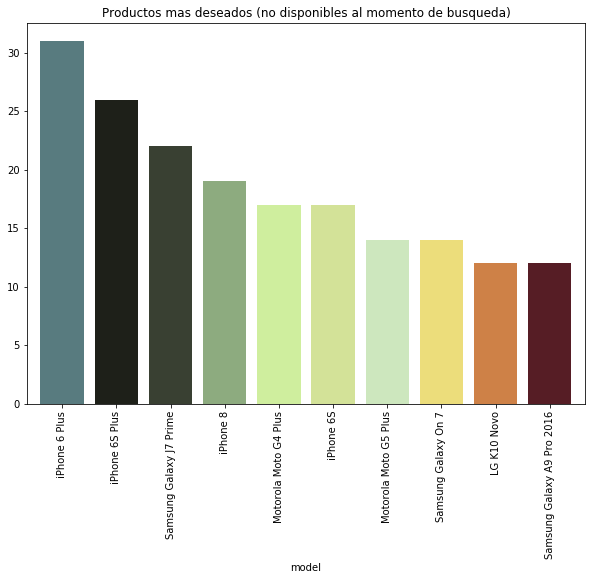

In [64]:
#Productos mas deseados y que no estaban disponibles
plot = events.loc[events['event'] == 'lead'].groupby('model').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10, 7), width=0.8, title="Productos mas deseados (no disponibles al momento de busqueda)", color=['#587b7f', '#1e2019', '#394032', '#8dab7f', '#cfee9e', '#d3e298', '#cde7be', '#ecdd7b', '#ce8147', '#561d25'])
plot.get_figure().savefig("st_lead_products.jpg")

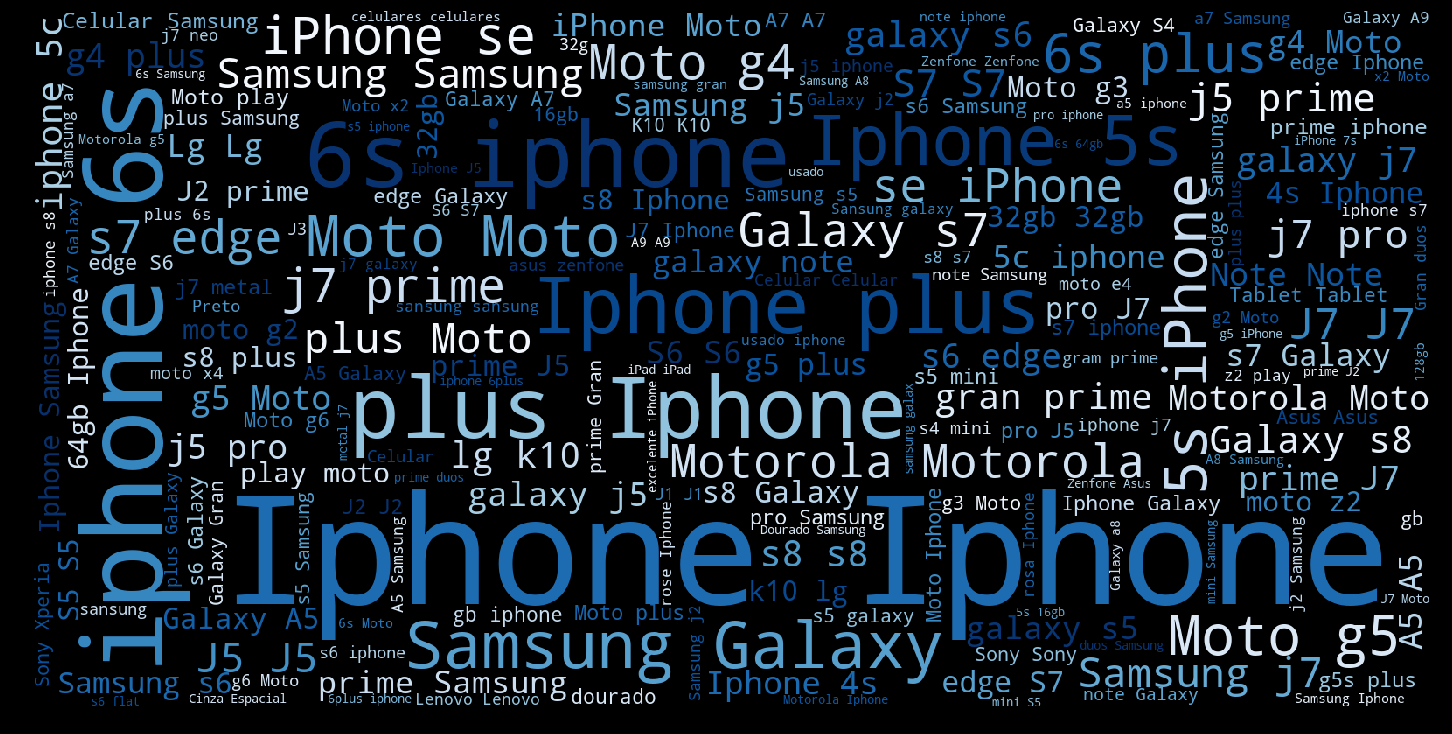

In [81]:
#Wordcloud de terminos buscados (200)
searched_words = events.loc[(events['event'] == 'searched products') & (~events['search_term'].isnull()) & (events['search_term'] != ''), :]['search_term']

wc = WordCloud(width=1600, height=800, max_words=200, colormap="Blues").generate(' '.join(searched_words))
plt.pyplot.figure(figsize=(20, 10), facecolor='k')
wc_most_searched_words = plt.pyplot.imshow(wc)
plt.pyplot.axis("off")
plt.pyplot.tight_layout(pad=0)
plt.pyplot.show()
wc_most_searched_words.get_figure().savefig('wordcloud.jpg', facecolor='k', bbox_inches='tight')